In [1]:
import pandas as pd
import numpy as np
import random
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

df = pd.read_csv('yelp_reviews.csv')

df.head()

,Name,Location,Rating,Date,Text
0,Laura W.,"Houston, TX",5 star rating,19-Aug-24,I share a birthday with a friend and Brennan's...
1,Simone P.,"Edgehill, Nashville, TN",2 star rating,17-Aug-24,I went for Houston restaurant week and ordered...
2,S P.,"Bellaire, TX",3 star rating,17-Aug-24,We are here before seeing Hairspray at Hobby t...
3,Michelle W.,"Houston, TX",3 star rating,16-Aug-24,"I hate to say it, but their brunch HRW menu di..."
4,Anthony D.,"San Francisco, CA",5 star rating,11-Aug-24,We made reservations for the Brennan's Kitche...


In [2]:
# Create copies of the dataset to test out different methods for sentiment analysis
df_vader = df.copy()
df_tb = df.copy()
df_lda = df.copy()

In [3]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Funciton to generate sentiment scores using VADER
def get_vader_sentiment(text):
    sentiment_dict = analyzer.polarity_scores(text)
    if sentiment_dict['compound'] >= 0.05:
        sentiment = 'Positive'
    elif sentiment_dict['compound'] <= 0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return pd.Series([sentiment_dict['compound'], sentiment])

# Apply the function to the DataFrame
df_vader[['Sentiment Score', 'Overall Sentiment']] = df_vader['Text'].apply(get_vader_sentiment)

# Display the DataFrame
print(df_vader)

            Name                 Location         Rating       Date  \
0       Laura W.              Houston, TX  5 star rating  19-Aug-24   
1      Simone P.  Edgehill, Nashville, TN  2 star rating  17-Aug-24   
2           S P.             Bellaire, TX  3 star rating  17-Aug-24   
3    Michelle W.              Houston, TX  3 star rating  16-Aug-24   
4     Anthony D.        San Francisco, CA  5 star rating  11-Aug-24   
..           ...                      ...            ...        ...   
95    Abigail C.              Liberty, TX  5 star rating  12-May-23   
96      Shawn A.                Miami, FL  5 star rating  30-Apr-23   
97      Frank R.              Houston, TX  5 star rating  25-Apr-23   
98  Christina R.                   TX, TX  5 star rating  15-Apr-23   
99    Jeanine M.        Missouri City, TX  5 star rating  10-Apr-23   

                                                 Text  Sentiment Score  \
0   I share a birthday with a friend and Brennan's...           0.9831   

In [4]:
df_vader['Sentiment Score'].describe()

count    100.000000
mean       0.795375
std        0.405802
min       -0.867300
25%        0.848250
50%        0.940200
75%        0.968500
max        0.998300
Name: Sentiment Score, dtype: float64

In [5]:
# Function to get sentiment scores using TextBlob
def get_tb_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    if sentiment.polarity > 0:
        overall_sentiment = 'Positive'
    elif sentiment.polarity < 0:
        overall_sentiment = 'Negative'
    else:
        overall_sentiment = 'Neutral'
    return pd.Series([sentiment.polarity, sentiment.subjectivity, overall_sentiment])

# Apply the function to the DataFrame
df_tb[['Polarity', 'Subjectivity', 'Overall Sentiment']] = df['Text'].apply(get_tb_sentiment)

# Display the DataFrame
print(df_tb)

            Name                 Location         Rating       Date  \
0       Laura W.              Houston, TX  5 star rating  19-Aug-24   
1      Simone P.  Edgehill, Nashville, TN  2 star rating  17-Aug-24   
2           S P.             Bellaire, TX  3 star rating  17-Aug-24   
3    Michelle W.              Houston, TX  3 star rating  16-Aug-24   
4     Anthony D.        San Francisco, CA  5 star rating  11-Aug-24   
..           ...                      ...            ...        ...   
95    Abigail C.              Liberty, TX  5 star rating  12-May-23   
96      Shawn A.                Miami, FL  5 star rating  30-Apr-23   
97      Frank R.              Houston, TX  5 star rating  25-Apr-23   
98  Christina R.                   TX, TX  5 star rating  15-Apr-23   
99    Jeanine M.        Missouri City, TX  5 star rating  10-Apr-23   

                                                 Text  Polarity  Subjectivity  \
0   I share a birthday with a friend and Brennan's...  0.464286   

In [11]:
# Calculate summary statistics
summary_stats = df_tb[['Polarity', 'Subjectivity']].describe()
print(summary_stats)

         Polarity  Subjectivity
count  100.000000    100.000000
mean     0.403489      0.638613
std      0.220203      0.123800
min     -0.176190      0.375000
25%      0.286667      0.548306
50%      0.397600      0.625025
75%      0.541111      0.716905
max      0.950000      0.937500


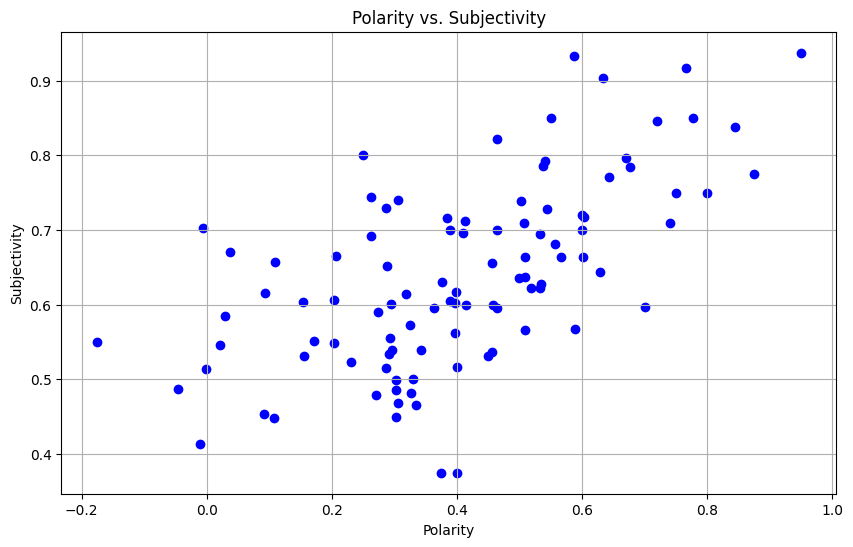

In [8]:
# Create a scatterplot to compare polarity and subjectivity

plt.figure(figsize=(10, 6))
plt.scatter(df_tb['Polarity'], df_tb['Subjectivity'], color='blue')
plt.title('Polarity vs. Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid(True)
plt.show()

In [9]:
# Calculate the correlation between polarity and subjectivity
correlation = df_tb['Polarity'].corr(df_tb['Subjectivity'])

# Display correlation
correlation

0.6125844267227848

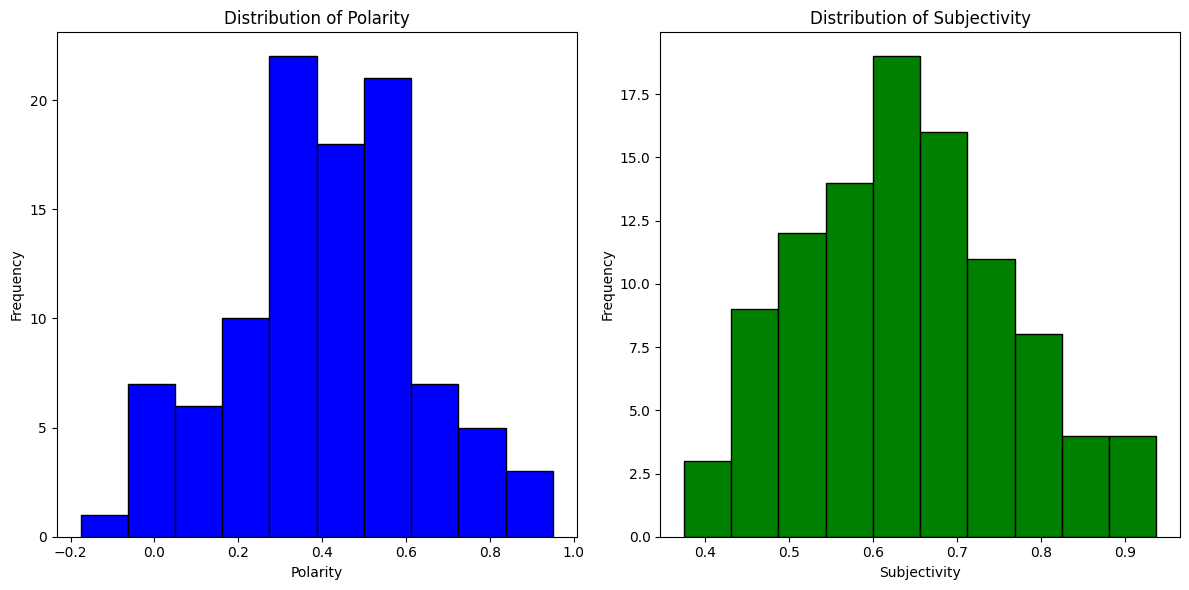

In [10]:
# Plot distributions

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.hist(df_tb['Polarity'], bins=10, color='blue', edgecolor='black')
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_tb['Subjectivity'], bins=10, color='green', edgecolor='black')
plt.title('Distribution of Subjectivity')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
# Assign stop words for LDA analysis
stop_words = set(stopwords.words('english'))

# Function to preprocess text data
def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic words
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Apply the funciton to the DataFrame
df_lda['Processed_Review'] = df_lda['Text'].apply(preprocess)

In [13]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df_lda['Processed_Review'])

# Filter out extreme values
dictionary.filter_extremes(no_below=1, no_above=0.5)

# Create the Bag-of-words model for each document
corpus = [dictionary.doc2bow(text) for text in df_lda['Processed_Review']]

In [14]:
# Set parameters for LDA
num_topics = 5
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Print the topics 
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.009*"soup" + 0.009*"houston" + 0.009*"restaurant" + 0.009*"great"')
(1, '0.019*"great" + 0.011*"brennan" + 0.009*"delicious" + 0.008*"place"')
(2, '0.012*"brennan" + 0.008*"restaurant" + 0.007*"wonderful" + 0.007*"made"')
(3, '0.011*"good" + 0.011*"great" + 0.009*"table" + 0.008*"friends"')
(4, '0.008*"crab" + 0.008*"sweet" + 0.007*"without" + 0.006*"soup"')


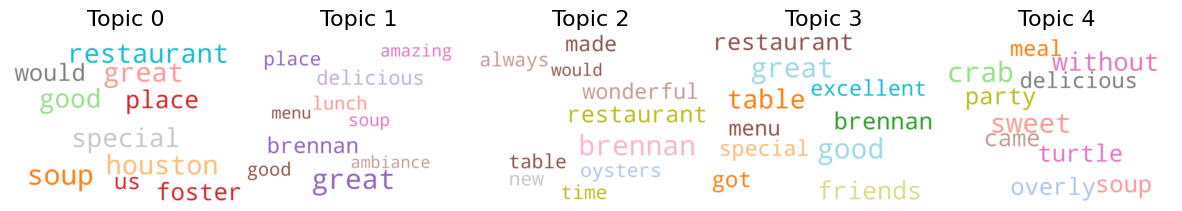

In [15]:
# Function to plot word cloud
def plot_word_cloud(lda_model, num_topics, dictionary):
    cols = plt.cm.tab20.colors

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab20',
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(1, num_topics, figsize=(15, 15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_title('Topic ' + str(i), fontdict=dict(size=16))
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

plot_word_cloud(lda_model, num_topics, dictionary)

In [16]:
# Function to format topics
def format_topics(lda_model, corpus, texts):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], axis=0)
    
    sent_topics_df = pd.concat([sent_topics_df.reset_index(drop=True), pd.Series(texts)], axis=1)

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df.reset_index(drop=True), contents], axis=1)
    
    return sent_topics_df

# Format topics
df_topic_sents_keywords = format_topics(lda_model, corpus, df_lda['Processed_Review'])
#df_topic_sents_keywords.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']

# Display the DataFrame
df_topic_sents_keywords.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Processed_Review,Processed_Review
0,2,0.9593,"brennan, restaurant, wonderful, made, always, ...","[share, birthday, friend, brennan, favorite, p...","[share, birthday, friend, brennan, favorite, p..."
1,0,0.9761,"soup, houston, restaurant, great, special, goo...","[went, houston, restaurant, week, ordered, tur...","[went, houston, restaurant, week, ordered, tur..."
2,0,0.9788,"soup, houston, restaurant, great, special, goo...","[seeing, hairspray, hobby, taking, advantage, ...","[seeing, hairspray, hobby, taking, advantage, ..."
3,4,0.9897,"crab, sweet, without, soup, turtle, party, ove...","[hate, say, brunch, hrw, menu, came, saturday,...","[hate, say, brunch, hrw, menu, came, saturday,..."
4,2,0.9792,"brennan, restaurant, wonderful, made, always, ...","[made, reservations, brennan, kitchen, experie...","[made, reservations, brennan, kitchen, experie..."
